In [19]:
import tspyro
import tskit
import tsdate

import numpy as np
import msprime
import torch
from pyro import poutine

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs


from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

import pyslim

# Example 1: A tree sequence produced by msprime (no locations)

In [2]:
ts = tskit.load("coalescent_sim.trees")
# This tree sequence can be reproduced with the following code:
# ts = msprime.simulate(500, Ne=2000, mutation_rate=1e-8, recombination_rate=1e-8, random_seed=1)

In [3]:
ts

In [5]:
# We can estimate the times of the tree sequence (without location)
# Specify the correct Ne and mutation rate
priors = tsdate.build_prior_grid(ts, Ne=2000)
inferred_times_marginal, _, _, guide_marginal, losses_marginal = tspyro.models.fit_guide(
    ts, leaf_location=None, priors=priors, mutation_rate=1e-8, steps=10000, log_every=1000)

step 0 loss = 17.686, Migration scale= 0.9950327277183533
step 1000 loss = 1.9799, Migration scale= 1.0220550298690796
step 2000 loss = 2.1186, Migration scale= 1.013162612915039
step 3000 loss = 2.7436, Migration scale= 0.9747270941734314
step 4000 loss = 2.2124, Migration scale= 0.9452072978019714
step 5000 loss = 2.0752, Migration scale= 1.0712567567825317
step 6000 loss = 2.7762, Migration scale= 1.1278220415115356
step 7000 loss = 2.2667, Migration scale= 1.071947693824768
step 8000 loss = 2.3811, Migration scale= 1.0437334775924683
step 9000 loss = 2.3481, Migration scale= 1.0606372356414795


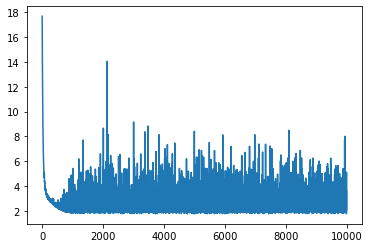

In [6]:
plt.plot(losses_marginal)

Text(0, 0.5, 'tspyro estimated times (generations)')

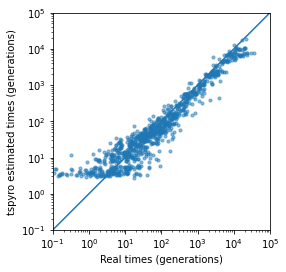

In [7]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect('equal')
ax.scatter(ts.tables.nodes.time, inferred_times_marginal, s=10, alpha=0.5)
ax.set_xlim(0.1, 100000)
ax.set_ylim(0.1, 100000)
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(plt.xlim(), plt.ylim())
ax.set_xlabel("Real times (generations)")
ax.set_ylabel("tspyro estimated times (generations)")

# Example 2: SLiM tree sequence

In [8]:
ts = tskit.load("slim_2d_continuous.trees")

In [9]:
# The tree sequence needs to be recapitated (so each tree has one root) and mutated (to add mutations)
ts = pyslim.recapitate(ts, recombination_rate=1e-8, ancestral_Ne=500, random_seed=1)
ts = msprime.mutate(ts, rate=1e-8, random_seed=1)
# Now let's randomly sample 200 leaf nodes
rng = np.random.default_rng(20)
random_sample = np.random.choice(np.arange(0, ts.num_samples), 200, replace=False)
sampled_ts = ts.simplify(samples=random_sample)

In [10]:
sampled_ts

In [11]:
# Next, we need to get the locations of the nodes
node_locations = np.full((sampled_ts.num_nodes, 2), -1, dtype=float)
no_location_nodes = []
for node in sampled_ts.nodes():
    if node.individual != -1:
        node_locations[node.id, :] = sampled_ts.individual(node.individual).location[:2]
    else:
        no_location_nodes.append(node.id)
# We want a tensor with only the leaf nodes for inference
leaf_locations = torch.tensor(node_locations[sampled_ts.samples()])



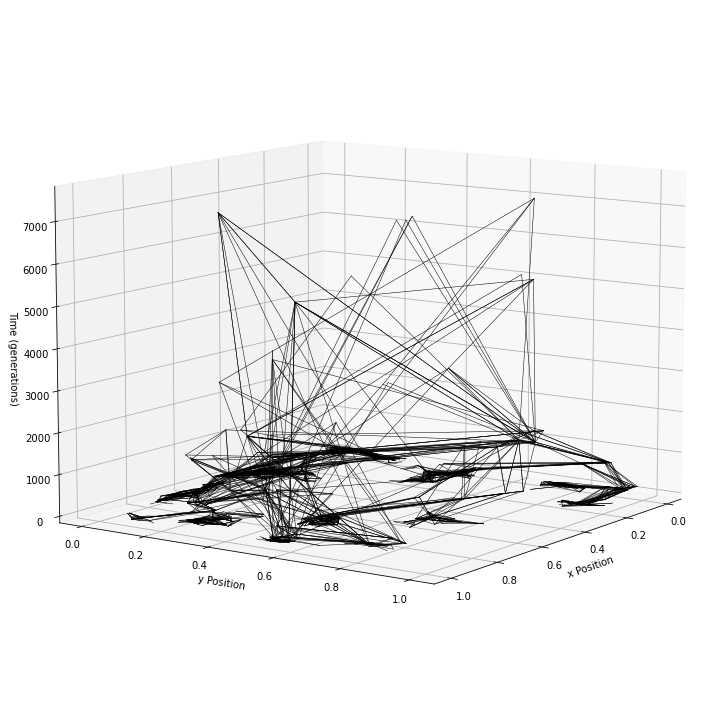

In [12]:
# Let's visualize the tree sequence in three dimensions
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
times = sampled_ts.tables.nodes.time
for edge in sampled_ts.edges():
    if edge.parent not in no_location_nodes:
        child_loc = node_locations[edge.child]
        parent_loc = node_locations[edge.parent]
        ax.plot([child_loc[0], parent_loc[0]], [child_loc[1], parent_loc[1]], [times[edge.child], times[edge.parent]],
               color="black", linewidth=0.5)

ax.set_xlabel("x Position")
ax.set_ylabel("y Position")
ax.set_zlabel("Time (generations)")
ax.view_init(10, 35)
plt.tight_layout()

In [14]:
# Let's perform joint inference of time and location

# We restrict inference of locations to nodes within 100 generations of the samples (which are all at time zero)
masked = sampled_ts.tables.nodes.time >= 100
mask = torch.ones(sampled_ts.num_edges, dtype=torch.bool)
for e, edge in enumerate(sampled_ts.edges()):
    if masked[edge.child]:
        mask[e] = False
migration_likelihood = tspyro.models.euclidean_migration
migration_likelihood = poutine.mask(
    migration_likelihood, mask=mask)

priors = tsdate.build_prior_grid(sampled_ts, Ne=1000)
inferred_times, inferred_locations, migration_scale, guide, losses = tspyro.models.fit_guide(
    sampled_ts, leaf_location=leaf_locations,
    migration_likelihood=migration_likelihood,
    priors=priors, mutation_rate=1e-8, steps=10000, log_every=1000)



step 0 loss = 27.539, Migration scale= 0.9950136542320251
step 1000 loss = 0.96615, Migration scale= 0.014347758144140244
step 2000 loss = -0.66234, Migration scale= 0.008206965401768684
step 3000 loss = -1.2864, Migration scale= 0.007244548760354519
step 4000 loss = -0.68478, Migration scale= 0.00687428517267108
step 5000 loss = -1.3971, Migration scale= 0.006628580391407013
step 6000 loss = -1.2143, Migration scale= 0.006501711439341307
step 7000 loss = -0.99228, Migration scale= 0.006397421006113291
step 8000 loss = -1.2793, Migration scale= 0.006371322087943554
step 9000 loss = -1.37, Migration scale= 0.006281685084104538


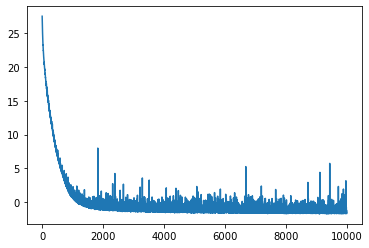

In [15]:
plt.plot(losses)

Text(0, 0.5, 'tspyro estimated times (generations)')

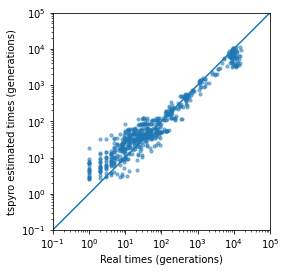

In [18]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect('equal')
ax.scatter(sampled_ts.tables.nodes.time, inferred_times, s=10, alpha=0.5)
ax.set_xlim(0.1, 100000)
ax.set_ylim(0.1, 100000)
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(plt.xlim(), plt.ylim())
ax.set_xlabel("Real times (generations)")
ax.set_ylabel("tspyro estimated times (generations)")